In [1]:
from __future__ import unicode_literals
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from helper_funcs import * 
import torch.nn as nn

import pandas as pd 
# prop = fm.FontProperties(fname='kalpurush ANSI.ttf')
# matplotlib.rcParams['font.family'] = prop.get_name()

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

from numpy import linalg as LA

import tensorboardX

batch_size=128
random_state = 42 

In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tb_writer = tensorboardX.SummaryWriter('storage/2fc-sl')


cuda:0


In [141]:
df = pd.read_csv("data/label-mappings.csv")

In [143]:
df[df.label == 771]

,Unnamed: 0,grapheme_root,vowel_diacritic,consonant_diacritic,label
771,771,102,0,0,771


In [157]:
def get_accuracy(testloader, net, batch=False):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            
            gt = 0 
            vt = 0 
            ct = 0 
            
            if batch: 
                overall = 100 * correct / total
                
                for (pred, label) in zip(predicted, labels):                    
                    l = label.item()
                    p = pred.item()
                    g, v, c = df[df.label == l].grapheme_root.values[0], \
                        df[df.label == l].vowel_diacritic.values[0], \
                        df[df.label == l].consonant_diacritic.values[0]
                    
                    pg, pv, pc = df[df.label == p].grapheme_root.values[0], \
                        df[df.label == p].vowel_diacritic.values[0], \
                        df[df.label == p].consonant_diacritic.values[0]   
                    
                    if g == pg: 
                        gt += 1 
                    if v == pv: 
                        vt += 1
                    if c == pc: 
                        ct+=1 
                g_acc = 100*gt/batch_size
                v_acc = 100*vt/batch_size
                c_acc = 100*ct/batch_size
                overall = (g_acc*2 + v_acc + c_acc) /4 
                
                return g_acc, v_acc, c_acc, overall
                
    overall = 100 * correct / total
    
    return overall

In [134]:
transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

trainset = BengaliDataset("data/train.csv","data/trainsplit", transform)
testset = BengaliDataset("data/test.csv","data/testsplit", transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

df = pd.read_csv("data/train.csv")
classes = list(range(df.label.max()+1))
n_classes = len(classes)

In [135]:
images, labels,t = next(iter(trainloader))

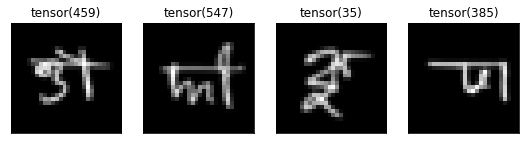

In [136]:
# show images
plot_gallery2(images,labels,1,4)

In [114]:
df.label.max()+1

1292

In [115]:
# Define our simple 2FC model:  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*13*13, 100)
        self.fc2 = nn.Linear(100, n_classes)
        self.ReLU = nn.ReLU()
        
        self.last_hidden = None

    def forward(self, x):
        x = self.conv(x)
        x = self.ReLU(x)
        x = self.pool(x)
        x = x.view(-1, 32*13*13)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_last_hidden(self,x):
        x = self.pool(self.ReLU(self.conv(x)))
        x = x.view(-1, 32*13*13)
        x = self.ReLU(self.fc1(x))
        return x 
    
net = Net().to(device)
output = net(images.to(device))

In [116]:
output.shape

torch.Size([128, 1292])

In [158]:
# Training with MSE/Quadratic loss 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

log_interval = 100
step = 0
# loop over the dataset multiple times
for epoch in range(20):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels, _ = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))        
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if (i+1) % log_interval == 0:    # print every 2000 mini-batches
            acc_g, acc_v, acc_c, overall = get_accuracy(testloader, net, batch=True)
            step_loss = running_loss / (log_interval+1)
            tb_writer.add_scalar("loss", loss, step)
            tb_writer.add_scalar("epoch_loss", running_loss, step)
            
            tb_writer.add_scalar("grapheme-root-accuracy", acc_g, step)
            tb_writer.add_scalar("vowel-diatric-accuracy", acc_v, step)
            tb_writer.add_scalar("consonant_diatric-accuracy", acc_c, step)
            tb_writer.add_scalar("accuracy", overall, step)


            print('[%d, %5d] loss: %.3f \t test accuracy: %.3f' % (epoch + 1, i + 1, loss, test_acc))
            
        step += 1 
                        

print('Finished Training')

642
85
906
115
979
124
971
123
977
123
851
112
1142
147
339
53
788
103
935
119
484
70
391
59
577
78
554
75
276
43
1077
138
1073
137
932
119
1212
152
833
107
1290
167
1021
132
973
123
433
64
1199
150
99
22
967
123
1178
149
5
3
119
23
303
48
306
48
1
1
625
81
894
115
143
23
1183
149
840
109
287
44
975
123
1257
159
888
115
1222
153
900
115
1176
149
32
13
479
69
786
103
973
123
1220
153
776
103
201
33
826
107
768
101
999
127
366
56
1076
138
268
43
995
125
1176
149
1212
152
1045
133
21
13
197
32
1131
146
971
123
931
119
1153
147
23
13
1009
128
1015
129
183
29
401
59
800
106
302
48
517
72
897
115
951
122
309
49
1278
165
110
22
1247
159
506
72
160
27
656
86
245
40
214
37
907
115
1094
139
1048
133
553
75
1256
159
406
60
906
115
113
22
908
115
224
38
763
100
990
124
691
91
508
72
807
107
470
67
992
125
488
71
455
65
1108
141
56
14
535
72
1098
140
663
87
290
44
780
103
1226
154
983
124
582
79
105
22
982
124
451
64
720
96
1202
151
1144
147
1125
144
1062
135
85
18
849
112
1162
148
853
112
[1,    1

KeyboardInterrupt: 

In [ ]:
# CrossEntropyLoss model 
print_accuracy(testloader, net)

In [ ]:
# Accuracy of a single batch of data: 
total = 0
correct = 0
with torch.no_grad():
    images, labels, _ = next(iter(testloader))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum().item()

In [ ]:
total, correct

In [152]:
df[df.label==771].grapheme_root.values[0]

102